#  Examples and Figures Used for Manuscript

pyMCR is a small package for performing multivariate curve resolution. Currently, it implements a simple alternating regression (MCR-AR) scheme. When the regressors are ordinary least-squares, this is MCR-alternating least-squares (MCR-ALS).


**MCR assumes a system of the form: D = CS^T**
    
Data that you will provide (hyperspectral context):
    
`D [n_pixels, n_frequencies]  # Hyperspectral image unraveled in space (2D)`
    
`initial_spectra [n_components, n_frequencies]  ## S^T in the literature`
    
OR

`initial_conc [n_pixels, n_components]   ## C in the literature`

If you have an initial estimate of the spectra

`mcrar.fit(D, ST=initial_spectra)`

Otherwise, if you have an initial estimate of the concentrations

`mcrar.fit(D, C=initial_conc)`

In [1]:
import datetime

import numpy as np

from scipy.sparse.linalg import svds
from scipy.stats import iqr

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

import seaborn as sns
import pandas as pd

# importing pymcr pieces
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from pymcr.metrics import mse
from pymcr.constraints import Constraint

from lmfit.models import GaussianModel, ConstantModel

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from timeit import default_timer as timer

# Class & Function Defs

In [2]:
class ConstraintSingleGauss(Constraint):
    """
    Perform a nonlinear least-squares fitting to enforce a Gaussian. 

    Parameters
    ----------
    copy : bool
        Make copy of input data, A; otherwise, overwrite (if mutable)
        
    axis : int
            Axis to perform fitting over
            
    """
    def __init__(self, alpha=1.0, copy=False, axis=-1):
        """ A must be non-negative"""
        self.copy = copy
        self.axis = axis
        if (alpha >= 0.0) & (alpha <= 1.0):
            self.alpha = alpha
        else:
            raise ValueError('alpha must be between 0.0 and 1.0')
        self._lmout_ = None
        
    def transform(self, A):
        """ Fit """
        n_components = list(A.shape)
        x = np.arange(n_components[self.axis])
        n_components.pop(self.axis)
        assert len(n_components)==1, "Input must be 2D"
        n_components = n_components[0]
        
        A_fit = 0*A
        
        for num in range(n_components):
            if (self.axis == -1) | (self.axis == 1):
                y = A[num, :]
            else:
                y = A[:, num]
                
            gmod = GaussianModel()
            cmod = ConstantModel()

            cmod.set_param_hint('c', min=y.min(), value=1000.0)
            pars = cmod.make_params()

            gmod.set_param_hint('amplitude', min=0)
            gmod.set_param_hint('center', min=x.min())
            pars += gmod.guess(y, x=x)

            mod = gmod + cmod
            out = mod.fit(y, pars, x=x)
            self._lmout_ = out
            
            if (self.axis == -1) | (self.axis == 1):
                A_fit[num,:] = 1*out.best_fit
            else:
                A_fit[:, num] = 1*out.best_fit
            
        if self.copy:
            return self.alpha*A_fit + (1-self.alpha)*A
        else:
            temp = 1*A
            A *= 0
            A += self.alpha*A_fit + (1-self.alpha)*temp
            return A

# Parameters

In [3]:
SAVEFIG = True
fig_prefix = 'NJRes_Model1'
now = datetime.datetime.now()
date_prefix = now.strftime('%y%m%d_%H%M')
np.random.seed(0)

# Define model system

## Initial spectal components

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


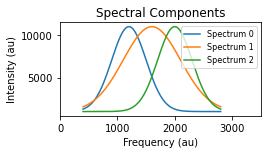

In [4]:
wn = np.linspace(400,2800,200)

n_components = 3

sp0 = 1e4*np.exp(-(wn-1200)**2/(2*300**2)) + 1000
sp1 = 1e4*np.exp(-(wn-1600)**2/(2*500**2)) + 1000
sp2 = 1e4*np.exp(-(wn-2000)**2/(2*300**2)) + 1000

plt.figure(figsize=[4,2.25])
plt.plot(wn, sp0, label='Spectrum 0')
plt.plot(wn, sp1, label='Spectrum 1')
plt.plot(wn, sp2, label='Spectrum 2')
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.legend(loc='best')
plt.title('Spectral Components')
plt.axis(xmin=0, xmax=3500)
plt.tight_layout()

if SAVEFIG:
    plt.savefig('./{}_{}_Model_Spectra.eps'.format(date_prefix,fig_prefix))

## Concentration map

Model starts off as 3 2D-Gaussian centered at (x*, y*) with standard deviation R (1 for each component).

The sum to 1 constraint is then enforced.

In [5]:
x0 = 10
y0 = 10

x1 = 90
y1 = 10

x2 = 50
y2 = 50

R0 = 20
R1 = 20
R2 = 20

M=50  # rows (Y)
N= 100  # cols (X)

# Init concentration map
conc = np.zeros((M,N,n_components))

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R0**2))*np.exp(-(Y-y0)**2/(2*R0**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R1**2))*np.exp(-(Y-y1)**2/(2*R1**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R2**2))*np.exp(-(Y-y2)**2/(2*R2**2))

conc /= conc.sum(axis=-1)[:,:,None]

# Find the maximum concentration (per component)
# and set to conc = 1 (and make the rest 0's)
# This just ensures that each component has a pure
# pixel somewhere within the image
for num in range(n_components):
    idx_m, idx_n = np.where(conc[..., num] >= 0.999 * conc[..., num].max())
    conc[idx_m, idx_n, :] = 0
    conc[idx_m, idx_n, num] = 1
conc /= conc.sum(axis=-1)[:,:,None]

new_conc = 1*conc
rad = 5
for num_m in range(3):
    for num_n in range(6):
        vec = np.array([0.,0.,0.])
        temp = np.random.randint(0,3,size=2)
        while np.unique(temp).size==1:
            temp = np.random.randint(0,3,size=2)
        temp.sort()
        vec[temp] = np.random.dirichlet([1,1])
        new_conc[(X-num_n*15-10)**2 + (Y-num_m*15-10)**2 < rad**2] = vec[None,:]

conc = 1*new_conc
conc /= conc.sum(axis=-1)[:,:,None]

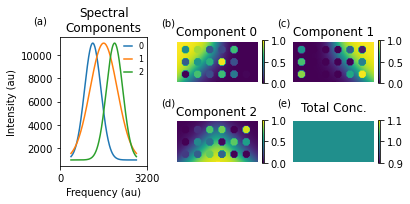

In [6]:
plt.figure(figsize=(5.5,4))

plt.subplot2grid((4,3),loc=[1,0],rowspan=2)
plt.plot(wn, sp0, label='0')
plt.plot(wn, sp1, label='1')
plt.plot(wn, sp2, label='2')
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.legend(loc='upper right', frameon=False, borderpad=0, handlelength=1)
plt.title('Spectral\nComponents')
# plt.axis(xmin=0, xmax=3000)
plt.xticks((0, 3200))
plt.text(-1000,1.1*plt.axis()[-1],'(a)')

plt.subplot2grid((4,3),loc=[1,1], rowspan=1)
plt.imshow(conc[...,0]);
plt.colorbar(fraction=0.025)
plt.axis('off')
plt.title('Component {}'.format(0))
plt.text(-20,-20,'(b)')

plt.subplot2grid((4,3),loc=[1,2], rowspan=1)
plt.imshow(conc[...,1]);
plt.colorbar(fraction=0.025)
plt.axis('off')
plt.title('Component {}'.format(1))
plt.text(-20,-20,'(c)')

plt.subplot2grid((4,3),loc=[2,1], rowspan=1)
plt.imshow(conc[...,2]);
plt.colorbar(fraction=0.025)
plt.axis('off')
plt.title('Component {}'.format(2))
plt.text(-20,-20,'(d)')

plt.subplot2grid((4,3),loc=[2,2], rowspan=1)
plt.imshow(conc.sum(axis=-1), clim=[0.9, 1.1]);
plt.colorbar(fraction=0.025)
plt.axis('off')
plt.axis('equal')
plt.title('Total Conc.')
plt.text(-20,-20,'(e)')

plt.tight_layout(pad=0, h_pad=0, w_pad=-1)
if SAVEFIG:
    plt.savefig('./{}_{}_Model_Conc_Spectra_Compound.eps'.format(date_prefix, fig_prefix))

In [7]:
# A spatially-unraveled copy of conc for error calcs
conc_ravel = conc.reshape((-1, n_components))

# Stack 3 spectral vectors into 1 matrix
spectra = np.vstack((sp0, sp1, sp2))

# Hyperspectral image (HSI)
hsi = np.dot(conc, spectra)

hsi_ravel = hsi.reshape((-1, wn.size)) + 250*np.random.randn(M*N,wn.size)
# hsi_ravel = hsi.reshape((-1, wn.size))

## Spectral Guess

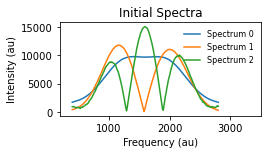

In [8]:
U,s,Vh = svds(hsi_ravel, k=4)
Vh = Vh[np.flip(np.argsort(s))[:-1],:]
initial_spectra = np.abs(Vh)/Vh.max()*hsi_ravel.max()

plt.figure(figsize=[4,2.25])
plt.plot(wn, initial_spectra[0,:], label='Spectrum 0')
plt.plot(wn, initial_spectra[1,:], label='Spectrum 1')
plt.plot(wn, initial_spectra[2,:], label='Spectrum 2')
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
lgd = plt.legend(loc='best', frameon=False)

plt.title('Initial Spectra')
plt.axis(xmin=200, xmax=3500)
plt.tight_layout()
if SAVEFIG:
    plt.savefig('./{}_{}_Spectra_Guess.eps'.format(date_prefix, fig_prefix))
    

# Run Sims

In [9]:
comparison_metrics = {
    'method' : [],
    'method_iter' : [],
    'component' : [],
    'mse' : [],
    'max_C_diff' : [],
    'min_C_diff' : [],
    'mean_C_diff' : [],
    'median_C_diff' : [],
    'std_C_diff' : [],
    'max_ST_diff' : [],
    'min_ST_diff' : [],
    'mean_ST_diff' : [],
    'median_ST_diff' : [],
    'std_ST_diff' : [],
    'n_iter' : [],
    'n_iter_opti' : [],
    'timer' : [],
    'time_per_iter' : []
}

method_list = ['MCR-ALS', 'MCR-NNLS', 'MCR-AR Gauss', 'MCR-AR Ridge', 'MCR-AR Lasso']

st_regr_list = ['OLS', 'NNLS', 'NNLS', Ridge(alpha=10, fit_intercept=False, random_state=0), 'OLS']
c_regr_list = ['OLS', 'NNLS', 'NNLS', 'OLS', Lasso(alpha=1, fit_intercept=True, positive=True, random_state=0)]
c_constr_list = [[ConstraintNonneg(), ConstraintNorm()],
                 [ConstraintNorm()],
                 [ConstraintNonneg(), ConstraintNorm()],
                 [ConstraintNonneg(), ConstraintNorm()],
                 [ConstraintNonneg(), ConstraintNorm()]
                ]
st_constr_list = [[ConstraintNonneg()],
                  [],
                  [ConstraintNonneg(), ConstraintSingleGauss(alpha=1)],
                  [ConstraintNonneg()],
                  [ConstraintNonneg()]
                  ]

n_retest =1
ar_tol = {'max_iter':1000, 'tol_increase':1e10, 'tol_n_increase':10000, 'tol_n_above_min':10000, 'tol_err_change':1e-14}


In [10]:
mcr = []

isolate_method = []

for num_method, (method, c_regr, st_regr, c_constr, st_const) in enumerate(zip(method_list, 
                                                                               c_regr_list, 
                                                                               st_regr_list, 
                                                                               c_constr_list, 
                                                                               st_constr_list)):
    
    mcr.append(McrAR(**ar_tol, st_regr=st_regr, c_regr=c_regr,
                       c_constraints=c_constr,
                       st_constraints=st_const))
    mcr[num_method]._saveall_st = True
    if (len(isolate_method) == 0) or (num_method in isolate_method):
        for num in range(n_retest):
            print('-------- {} --------'.format(method))
            print('Trial {} / {}'.format(num + 1, n_retest))
            tmr = timer()
            mcr[num_method].fit(hsi_ravel, ST=1*initial_spectra, verbose=False)
            tmr -= timer()
            print('\nFinal MSE: {:.7e}'.format(mcr[num_method].err[-1]))

            comparison_metrics['method'].extend([method]*n_components)
            comparison_metrics['method_iter'].extend([num]*n_components)
            comparison_metrics['mse'].extend([np.min(mcr[num_method].err)]*n_components)

            comparison_metrics['component'].extend(range(n_components))
            
            # Find which MCR idx corresponds to the real data
            # Not a robust way of doing it (can get, e.g., [0,0,0])
            select = []
            for num in range(3):
                select.append(np.argmin(np.sum((mcr[num_method].C_opt_ - conc_ravel[:,num:num+1])**2, axis=0)))
#             print(select)
            comparison_metrics['max_C_diff'].extend((conc_ravel - mcr[num_method].C_opt_[:, select]).max(axis=0))
            comparison_metrics['min_C_diff'].extend((conc_ravel - mcr[num_method].C_opt_[:, select]).min(axis=0))
            comparison_metrics['mean_C_diff'].extend((conc_ravel - mcr[num_method].C_opt_[:, select]).mean(axis=0))
            comparison_metrics['median_C_diff'].extend(np.median(conc_ravel - mcr[num_method].C_opt_[:, select], axis=0))
            comparison_metrics['std_C_diff'].extend((conc_ravel - mcr[num_method].C_opt_[:, select]).std(axis=0))
            comparison_metrics['max_ST_diff'].extend((spectra - mcr[num_method].ST_opt_[select,:]).max(axis=1))
            comparison_metrics['min_ST_diff'].extend((spectra - mcr[num_method].ST_opt_[select,:]).min(axis=1))
            comparison_metrics['mean_ST_diff'].extend((spectra - mcr[num_method].ST_opt_[select,:]).mean(axis=1))
            comparison_metrics['median_ST_diff'].extend(np.median(spectra - mcr[num_method].ST_opt_[select,:], axis=1))
            comparison_metrics['std_ST_diff'].extend((spectra - mcr[num_method].ST_opt_[select,:]).std(axis=1))
            comparison_metrics['n_iter_opti'].extend(n_components*[mcr[num_method].n_iter_opt])
            comparison_metrics['n_iter'].extend(n_components*[mcr[num_method].n_iter])
            comparison_metrics['timer'].extend(n_components*[-tmr])
            comparison_metrics['time_per_iter'].extend(n_components*[-tmr/mcr[num_method].n_iter])
        print('MSE (w known): {:.2e}'.format(np.mean((hsi_ravel - mcr[num_method].D_opt_)**2)))
        print('MSE (w known): {:.2e}'.format(mse(mcr[num_method].C_opt_[:, select], mcr[num_method].ST_opt_[select,:],
                                                 hsi_ravel, 
                                                 mcr[num_method].D_opt_)))
        print('------------------')

-------- MCR-ALS --------
Trial 1 / 1
Change in err below tol_err_change (0.0000e+00). Exiting.

Final MSE: 1.8318030e+05
MSE (w known): 1.83e+05
MSE (w known): 1.83e+05
------------------
-------- MCR-NNLS --------
Trial 1 / 1
Max iterations reached (1000).

Final MSE: 6.3190034e+04
MSE (w known): 6.32e+04
MSE (w known): 6.32e+04
------------------
-------- MCR-AR Gauss --------
Trial 1 / 1
Max iterations reached (1000).

Final MSE: 6.4675259e+04
MSE (w known): 6.47e+04
MSE (w known): 6.47e+04
------------------
-------- MCR-AR Ridge --------
Trial 1 / 1
Change in err below tol_err_change (0.0000e+00). Exiting.

Final MSE: 1.6816735e+05
MSE (w known): 1.68e+05
MSE (w known): 1.68e+05
------------------
-------- MCR-AR Lasso --------
Trial 1 / 1
Max iterations reached (1000).

Final MSE: 6.3688317e+04
MSE (w known): 6.36e+04
MSE (w known): 6.36e+04
------------------


# Plot Comparisons

In [11]:
df_comparison = pd.DataFrame(comparison_metrics)

In [12]:
df_comparison.to_pickle('./{}_df_comparison.pickle'.format(date_prefix))
df_comparison.to_excel('./{}_190430_df_comparison.xlsx'.format(date_prefix))

In [13]:
xlabels = method_list


 --------------------- Delta S ---------------

 ['MCR-ALS', 'MCR-NNLS', 'MCR-AR Gauss', 'MCR-AR Ridge', 'MCR-AR Lasso']
Median  [  3.8618 -20.2129 121.7149 130.2588 203.7075]
Best Values: ['MCR-AR Gauss', 'MCR-AR Lasso', 'MCR-NNLS', 'MCR-ALS', 'MCR-AR Ridge']

Max  [  79.1297 1585.7168 1940.5036 3627.1876 3804.2803]
Best Values: ['MCR-AR Gauss', 'MCR-AR Lasso', 'MCR-NNLS', 'MCR-AR Ridge', 'MCR-ALS']

Min  [ -605.9947  -683.6784  -805.3248 -1278.5838 -2494.8729]
Best Values: ['MCR-AR Lasso', 'MCR-AR Ridge', 'MCR-ALS', 'MCR-AR Gauss', 'MCR-NNLS']

IQR  [ 146.1254  724.1878  945.7431 1028.3815 1096.9511]
Best Values: ['MCR-AR Gauss', 'MCR-AR Lasso', 'MCR-NNLS', 'MCR-AR Ridge', 'MCR-ALS']


 --------------------- Delta C ---------------

 ['MCR-ALS', 'MCR-NNLS', 'MCR-AR Gauss', 'MCR-AR Ridge', 'MCR-AR Lasso']
Median  [-0.0019  0.009   0.0108  0.0158  0.0218]
Best Values: ['MCR-AR Gauss', 'MCR-AR Lasso', 'MCR-NNLS', 'MCR-ALS', 'MCR-AR Ridge']

Max  [0.17   0.2195 0.2544 0.3422 0.3452]
Bes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

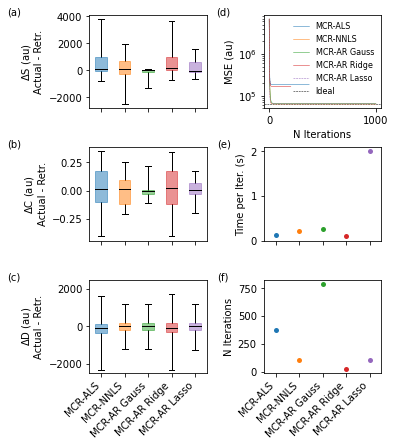

In [20]:
temp = []
for num in range(len(mcr)):
    # Find which MCR idx corresponds to the real data
    # Not a robust way of doing it (can get, e.g., [0,0,0])
    select = []
    for num2 in range(3):
        select.append(np.argmin(np.sum((mcr[num].C_opt_ - conc_ravel[:,num2:num2+1])**2, axis=0)))    
    try:
        temp.append((spectra - mcr[num].ST_opt_[select,:]).ravel())
    except:
        temp.append([])
print('\n','--------------------- Delta S ---------------')
print('\n', method_list)
metrics = np.median(temp, axis=-1).round(4)
print('Median ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.max(temp, axis=-1).round(4)
print('Max ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.min(temp, axis=-1).round(4)
print('Min ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = iqr(temp, axis=-1).round(4)
print('IQR ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))

plt.figure(figsize=(5.5,6))
plt.subplot(321)

out = plt.boxplot(temp, whis=[0,100], patch_artist=True);
for num in range(len(mcr)):
    out['boxes'][num].set_color('C{}'.format(num))
    out['medians'][num].set_color('k')
    out['boxes'][num].set_alpha(0.5)
# plt.gca().set_xticklabels(xlabels, rotation=45)
plt.gca().set_xticklabels(['','','','',''])
plt.ylabel('$\Delta$S (au)\nActual - Retr.');
plt.text(-3,plt.axis()[-1],'(a)')

plt.subplot(323)
temp = []

for num in range(len(mcr)):
    # Find which MCR idx corresponds to the real data
    # Not a robust way of doing it (can get, e.g., [0,0,0])
    select = []
    for num2 in range(3):
        select.append(np.argmin(np.sum((mcr[num].C_opt_ - conc_ravel[:,num2:num2+1])**2, axis=0)))
    try:
        temp.append((conc_ravel - mcr[num].C_opt_[:,select]).ravel())
    except:
        temp.append([])

print('\n','--------------------- Delta C ---------------')
print('\n', method_list)
metrics = np.median(temp, axis=-1).round(4)
print('Median ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.max(temp, axis=-1).round(4)
print('Max ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.min(temp, axis=-1).round(4)
print('Min ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = iqr(temp, axis=-1).round(4)
print('IQR ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))

out = plt.boxplot(temp, whis=[0,100], patch_artist=True);
for num in range(len(mcr)):
    out['boxes'][num].set_color('C{}'.format(num))
    out['medians'][num].set_color('k')
    out['boxes'][num].set_alpha(0.5)
# plt.gca().set_xticklabels(xlabels, rotation=45)
plt.gca().set_xticklabels(['','','','',''])
plt.ylabel('$\Delta$C (au)\nActual - Retr.');
plt.text(-3,plt.axis()[-1],'(b)')

temp = []
for num in range(len(mcr)):
    try:
#         temp.append(np.sum((hsi_ravel - mcr[num].D_opt_)**2, axis=-1))
        temp.append((hsi_ravel - mcr[num].D_opt_).ravel())
    except:
        temp.append([])
print('\n','--------------------- Delta D ---------------')
print('\n', method_list)
metrics = np.median(temp, axis=-1).round(4)
print('Median ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.max(temp, axis=-1).round(4)
print('Max ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = np.min(temp, axis=-1).round(4)
print('Min ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
metrics = iqr(temp, axis=-1).round(4)
print('IQR ', metrics[np.argsort(np.abs(metrics))])
print('Best Values: {}\n'.format([method_list[n] for n in np.argsort(np.abs(metrics)).tolist()]))
# plt.figure(figsize=(5.5,4))
# plt.subplot(221)

# plt.yscale('log')

plt.subplot(325)
out = plt.boxplot(temp, whis=[0,100], patch_artist=True);
for num in range(len(mcr)):
    out['boxes'][num].set_color('C{}'.format(num))
    out['medians'][num].set_color('k')
    out['boxes'][num].set_alpha(0.5)
# plt.gca().set_xticklabels(xlabels, rotation=45)
plt.gca().set_xticklabels(xlabels, rotation=45, horizontalalignment='right')

plt.axis(ymax=2500, ymin=-2500)
plt.ylabel('$\Delta$D (au)\nActual - Retr.');
plt.text(-3,plt.axis()[-1],'(c)')

plt.subplot(322)
for num, m in enumerate(mcr):
    if (num == 4):
        marker='None'
        ls='--'
    else:
        marker = None
        ls = '-'
    try:
        plt.semilogy(m.err, label=method_list[num], marker=marker, ls=ls, lw=0.5)
    except:
        pass0
plt.ylabel('MSE (au)')
plt.xlabel('N Iterations')
plt.text(-1*ar_tol['max_iter'],plt.axis()[-1],'(d)')
plt.xticks(ticks=[0,ar_tol['max_iter']*2], labels=['0',ar_tol['max_iter']])
t = plt.axis()
plt.hlines(np.sum(np.abs(hsi.reshape(*hsi_ravel.shape) - hsi_ravel)**2)/hsi.size, 2*t[0], t[1], 
           color='k', lw=0.5, linestyle='--', label='Ideal')
plt.legend(frameon=False)
plt.axis(t)
print('T:', t)

plt.subplot(324)
sns.swarmplot(x='method', y='time_per_iter', data=df_comparison[df_comparison['component']==0])
plt.ylabel('Time per Iter. (s)')
plt.xlabel('')
plt.axis(ymin=0)
plt.gca().set_xticklabels(['','','','',''])
plt.text(-2.5,plt.axis()[-1],'(e)')

plt.subplot(326)
sns.swarmplot(x='method', y='n_iter_opti', data=df_comparison[df_comparison['component']==0])
plt.ylabel('N Iterations')
plt.xlabel('')
plt.text(-2.5,plt.axis()[-1],'(f)')
plt.gca().set_xticklabels(xlabels, rotation=45, horizontalalignment='right')

plt.tight_layout(pad=0, w_pad=0, h_pad=0)

if SAVEFIG:
    plt.savefig('./{}_{}_Stats_Panel_eg1.eps'.format(date_prefix, fig_prefix))
# plt.savefig('NJRes_Stats_Panel_eg1.png')
plt.show()

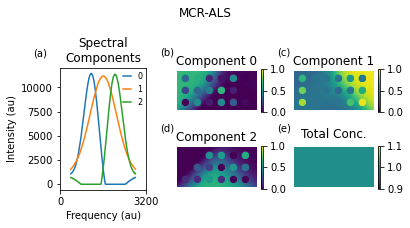

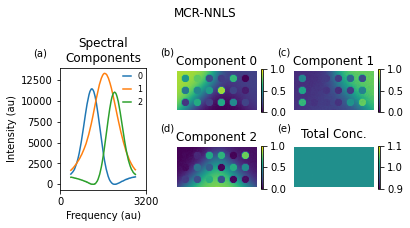

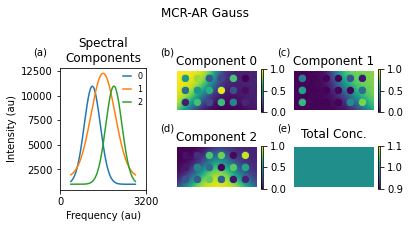

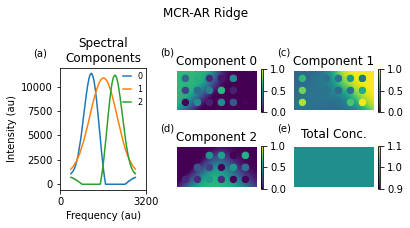

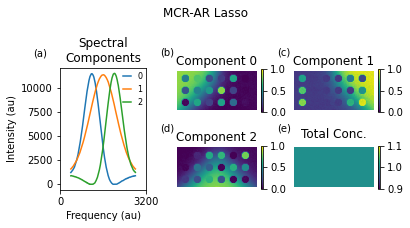

In [21]:

for mcr_select in range(len(method_list)):
    plt.figure(figsize=(5.5,4))
    plt.subplot2grid((4,3),loc=[1,0],rowspan=2)
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[0]], label='0')
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[1]], label='1')
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[2]], label='2')
    plt.xlabel('Frequency (au)')
    plt.ylabel('Intensity (au)')
    plt.legend(loc='upper right', frameon=False, borderpad=0, handlelength=1)
    plt.title('Spectral\nComponents')
    # plt.axis(xmin=0, xmax=3000)
    plt.xticks((0, 3200))
    plt.text(-1000,1.1*plt.axis()[-1],'(a)')

    plt.subplot2grid((4,3),loc=[1,1], rowspan=1)
    plt.imshow(mcr[mcr_select].C_opt_[...,select[0]].reshape(*conc[...,0].shape), clim=[0,1]);
    plt.colorbar(fraction=0.025)
    plt.axis('off')
    plt.title('Component {}'.format(0))
    plt.text(-22,-20,'(b)')

    plt.subplot2grid((4,3),loc=[1,2], rowspan=1)
    plt.imshow(mcr[mcr_select].C_opt_[...,select[1]].reshape(*conc[...,0].shape), clim=[0,1]);
    plt.colorbar(fraction=0.025)
    plt.axis('off')
    plt.title('Component {}'.format(1))
    plt.text(-22,-20,'(c)')

    plt.subplot2grid((4,3),loc=[2,1], rowspan=1)
    plt.imshow(mcr[mcr_select].C_opt_[...,select[2]].reshape(*conc[...,0].shape), clim=[0,1]);
    plt.colorbar(fraction=0.025)
    plt.axis('off')
    plt.title('Component {}'.format(2))
    plt.text(-22,-20,'(d)')

    plt.subplot2grid((4,3),loc=[2,2], rowspan=1)
    plt.imshow(mcr[mcr_select].C_opt_.sum(axis=-1).reshape(*conc[...,0].shape), clim=[0.9, 1.1]);
    # plt.imshow(conc.sum(axis=-1), clim=[0.9, 1.1]);
    plt.colorbar(fraction=0.025)
    plt.axis('off')
    plt.axis('equal')
    plt.title('Total Conc.')
    plt.text(-22,-20,'(e)')
    st = plt.suptitle(method_list[mcr_select])
    st.set_y(0.9)
    plt.tight_layout(pad=0, h_pad=0, w_pad=-1)
    if SAVEFIG:
        plt.savefig('./{}_{}_{}_Conc_Spectra_Compound.eps'.format(date_prefix, fig_prefix, method_list[mcr_select]))
    plt.show()